In [1]:
import yfinance as yf
import numpy as np
from classes.dataframe.EnhancedDataframe import EnhancedDataframe
import seaborn as sns
import matplotlib.pyplot as plt
from classes.database.SP500Database import SP500Database
from config import db_path
from classes.market_analysis.SP500Analysis import SP500Analysis

In [2]:
sp500_database = SP500Database()
sp500_database.connect_existing_database(db_path / "sp500.sqlite")
# populate_sp500(sp500_database, update=False)
market_analysis = SP500Analysis(sp500_database)

sefi = market_analysis.sefi()
adr = market_analysis.adr_analysis()

historical_data
2021-10-11 00:00:00 2022-05-20 00:00:00
len df:  254
len df:  155
historical_data


In [13]:
df = yf.download("MSFT", period="2y", interval="1d")
df = EnhancedDataframe.populate_dataframe(df, "SPX")

[*********************100%***********************]  1 of 1 completed


In [14]:
from classes.indicators.MomentumIndicators import get_atr

df["ATR"] = get_atr(df)

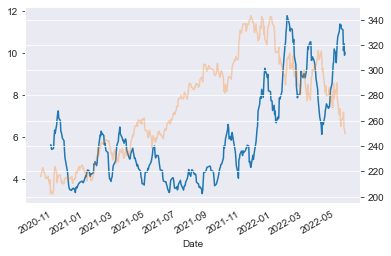

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
df['ATR'].plot(ax=ax)
df['Close'].plot(ax=ax, secondary_y=True, alpha=0.3)
plt.show()


[*********************100%***********************]  1 of 1 completed


In [1]:
import pandas as pd
import warnings
import yfinance
import numpy as np

warnings.filterwarnings("ignore")


def get_tr(high, low, previous_close):
    return max([(high - low), abs(high - previous_close), abs(low - previous_close)])


def get_atr(df: pd.DataFrame) -> pd.Series:
    df["TR"] = np.vectorize(get_tr)(df['High'], df['Low'], df['Close'].shift(1))
    atr = df["TR"].rolling(window=14).mean()
    return atr


def get_pdm(high, previous_high, low, previous_low):
    if (high - previous_high) > (previous_low - low) and (high - previous_high > 0):
        return float(high - previous_high)
    return float(0)


def get_ndm(high, previous_high, low, previous_low):
    if (previous_low - low) > (high - previous_high) and (previous_low - low > 0):
        return float(previous_low - low)
    return float(0)


def smooth_values(df, values, period, mean=False):
    is_truthy = False
    container = []
    for i, date in enumerate(df.index):
        try:
            if not np.isnan(values.loc[date]) and not is_truthy:
                is_truthy = True
                if not mean:
                    container.append(values[i:i + period].sum())
                else:
                    container.append(values[i:i + period].mean())
            elif is_truthy:
                if not mean:
                    container.append(container[-1] - (container[-1] / period) + values.iloc[i + period - 1])
                else:
                    container.append(((container[-1] * (period - 1)) + values.iloc[i]) / period)
        except IndexError:
            break
    return container


def match_len_and_populate_df(df: pd.DataFrame, container: list, colname: str) -> None:
    if len(df) != len(container):
        adapted_smoothed = np.zeros(len(df))
        gap = len(df) - len(container)
        adapted_smoothed[gap:] = container
        df[colname] = adapted_smoothed
    else:
        df[colname] = container


def get_pdi(spdm, atr):
    return (spdm / atr) * 100


def get_ndi(sndm, atr):
    return (sndm / atr) * 100


def get_dx(pdi, ndi):
    return ((abs(pdi - ndi)) / (pdi + ndi)) * 100


warnings.filterwarnings("ignore")

main_df = yfinance.download("AAPL", interval="1d", period="1y")

main_df['NDM'] = np.vectorize(get_ndm)(main_df['High'], main_df['High'].shift(1), main_df['Low'],
                                       main_df['Low'].shift(1))
main_df['PDM'] = np.vectorize(get_pdm)(main_df['High'], main_df['High'].shift(1), main_df['Low'],
                                       main_df['Low'].shift(1))
main_df["TR"] = np.vectorize(get_tr)(main_df["High"], main_df["Low"], main_df["Close"].shift())

# main_df["SPDM"] = main_df['NDM'].ewm(span=14, adjust=False).mean()
# main_df["SNDM"] = main_df['PDM'].ewm(span=14, adjust=False).mean()
# main_df["STR"] = main_df['TR'].ewm(span=14, adjust=False).mean()
#
main_df["SPDM"] = main_df['PDM'].rolling(window=14).mean()
main_df["SNDM"] = main_df['NDM'].rolling(window=14).mean()
main_df["ATR"] = main_df['TR'].rolling(window=14).mean()

# smoothed_pdm = smooth_values(main_df, main_df['PDM'], 14)
# smoothed_ndm = smooth_values(main_df, main_df['NDM'], 14)
# smoothed_tr = smooth_values(main_df, main_df['TR'], 14, mean=True)
# #
# match_len_and_populate_df(main_df, smoothed_pdm, "SPDM")
# match_len_and_populate_df(main_df, smoothed_ndm, "SNDM")
# match_len_and_populate_df(main_df, smoothed_tr, "STR")

# main_df.replace(0, np.nan, inplace=True)
main_df['PDMI'] = np.vectorize(get_pdi)(main_df['SPDM'], main_df['ATR'])
main_df['NDMI'] = np.vectorize(get_pdi)(main_df['SNDM'], main_df['ATR'])
main_df['DX'] = np.vectorize(get_dx)(main_df["PDMI"], main_df["NDMI"])
# main_df["ADX"] = main_df['DX'].ewm(span=14, adjust=False).mean()
main_df["ADX"] = main_df['DX'].rolling(window=14).mean()
# smoothed_dx = smooth_values(main_df, main_df['DX'], 14, mean=True)
# match_len_and_populate_df(main_df, smoothed_dx, "ADX")


[*********************100%***********************]  1 of 1 completed


In [2]:
main_df
# def get_pdm(high, previous_high, low, previous_low):
#     if (high - previous_high) > (previous_low - low) and (high - previous_high > 0):
#         return high - previous_high
#     return 0
#
#
# def get_ndm(high, previous_high, low, previous_low):
#     if (previous_low - low) > (high - previous_high) and (previous_low - low > 0):
#         return previous_low - low
#     return 0

# main_df['NDM'] = np.vectorize(get_ndm)(main_df['High'], main_df['High'].shift(1), main_df['Low'],
#                                        main_df['Low'].shift(1))
main_df

,Open,High,Low,Close,Adj Close,Volume,NDM,PDM,TR,ATR,SPDM,SNDM,PDMI,NDMI,DX,ADX
Date,,,,,,,,,,,,,,,,
2021-05-27,126.440002,127.639999,125.080002,125.279999,124.568321,94625600,0.000000,0.000000,2.559998,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN
2021-05-28,125.570000,125.800003,124.550003,124.610001,123.902115,71311100,0.529999,0.000000,1.250000,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN
2021-06-01,125.080002,125.349998,123.940002,124.279999,123.573982,67637100,0.610001,0.000000,1.409996,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN
2021-06-02,124.279999,125.239998,124.050003,125.059998,124.349564,59278900,0.000000,0.000000,1.189995,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN
2021-06-03,124.680000,124.849998,123.129997,123.540001,122.838196,76229200,0.920006,0.000000,1.930000,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-23,137.789993,143.259995,137.649994,143.110001,143.110001,117726300,0.000000,2.559998,5.669998,6.616432,13.051059,29.690924,197.252213,448.745238,38.930962,26.723068
2022-05-24,140.809998,141.970001,137.330002,140.360001,140.360001,104132700,0.319992,0.000000,5.779999,6.513575,12.118840,27.890136,186.055133,428.184778,39.419393,29.044418
2022-05-25,138.429993,141.789993,138.339996,140.520004,140.520004,92482700,0.000000,0.000000,3.449997,5.969288,11.253209,25.897984,188.518432,433.853781,39.419393,31.459437


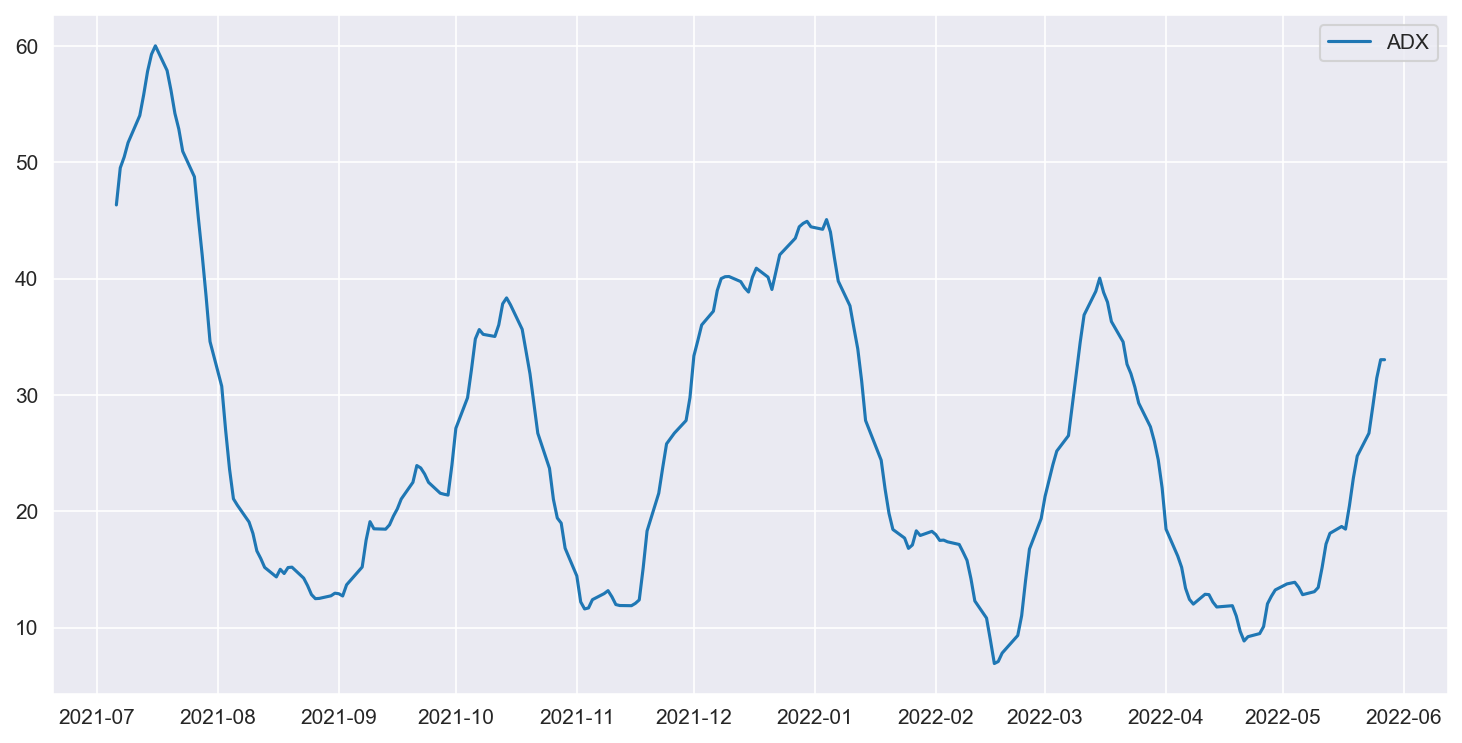

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6), dpi=150)
# plt.plot(main_df.index, main_df['PDMI'], label='PDMI')
# plt.plot(main_df.index, main_df['NDMI'], label='NDMI')
plt.plot(main_df.index, main_df['ADX'], label='ADX')
# plt.plot(main_df.index, main_df['STR'], label='STR')
plt.legend()